# 1.import library

In [1]:
import cv2
import gc
import io
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import tempfile
import threading
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import wandb
from concurrent.futures import ThreadPoolExecutor, as_completed
from scipy.interpolate import interp1d
from scipy.optimize import brentq
from sklearn.metrics import (roc_curve, recall_score, precision_score, accuracy_score, f1_score, roc_auc_score,
                             average_precision_score, confusion_matrix, classification_report, precision_recall_curve)
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import Dataset, DataLoader, Subset
from tqdm.notebook import tqdm

# 2.NpyLoader

In [2]:
class NpyLoader:
    """
    从 CSV 文件中加载音频数据的信息，不读取音频数据本身。
    CSV 文件应包含以下字段：
      - npy_path: mfcc对应npy文件路径
      - data_source: 数据源（例如 "itw"）
      - speaker: 说话人信息
      - Set: 数据集划分（例如 "train", "test", "in-test"）
      - label: 分类标签
    返回一个列表，每个元素为 (absolute_path, speaker, label)
    """

    def __init__(self, max_workers=96):
        self.max_workers = max_workers

    def load_audio_info_from_csv(self, csv_file, allowed_set=None, allowed_data_source="all"):
        # 读取 CSV 文件
        df = pd.read_csv(csv_file)

        # 根据 allowed_set 和 allowed_data_source 过滤数据
        if allowed_set is not None:
            df = df[df["Set"].isin(allowed_set)]
        if allowed_data_source != "all":
            df = df[df["data_source"].isin(allowed_data_source)]

        # 内部函数：从一行数据中提取所需信息
        def load_info(row):
            npy_path = row["npy_path"]
            speaker = row["speaker"]
            label = int(row["label"])  # 转换为 int 类型
            return (npy_path, speaker, label)

        records = []
        with ThreadPoolExecutor(max_workers=self.max_workers) as executor:
            # 提交任务
            futures = {executor.submit(load_info, row): idx for idx, row in df.iterrows()}
            # 利用 tqdm 显示进度条
            for future in tqdm(as_completed(futures), total=len(futures), desc="Loading audio info from CSV"):
                result = future.result()
                if result is not None:
                    records.append(result)
        return records

# 3.Spec-Augmentation

In [3]:
# ---------------------------
# SpecAugment 实现：Random TimeMask & Random FreqMask
# ---------------------------
def random_time_mask(spec, T=100, num_masks=1):
    """对时域进行随机遮挡
    spec: (n_mfcc, frames)
    T: 最大遮挡长度
    """
    spec = spec.copy()
    num_frames = spec.shape[1]
    for _ in range(num_masks):
        t = random.randint(0, T)
        if num_frames - t > 0:
            t0 = random.randint(0, num_frames - t)
            spec[:, t0:t0 + t] = 0
    return spec


def random_freq_mask(spec, F=10, num_masks=1):
    """对频域进行随机遮挡
    spec: (n_mfcc, frames)
    F: 最大遮挡频率数量
    """
    spec = spec.copy()
    num_mfcc = spec.shape[0]
    for _ in range(num_masks):
        f = random.randint(0, F)
        if num_mfcc - f > 0:
            f0 = random.randint(0, num_mfcc - f)
            spec[f0:f0 + f, :] = 0
    return spec


def spec_augment(spec, time_mask_param=30, freq_mask_param=8, num_time_masks=1, num_freq_masks=1):
    spec = random_time_mask(spec, T=time_mask_param, num_masks=num_time_masks)
    spec = random_freq_mask(spec, F=freq_mask_param, num_masks=num_freq_masks)
    return spec


# ---------------------------
# CutMix 实现
# ---------------------------
def cutmix_data(x, y, beta=1.0, cutmix_prob=0.2):
    """
    x: (B, C, H, W) batch 的特征图
    y: (B,) 标签
    返回：如果应用了 CutMix，则返回混合后的 x 和混合标签 (y_a, y_b, lam)
    """
    if random.random() < cutmix_prob:
        lam = np.random.beta(beta, beta)
        batch_size, C, H, W = x.shape
        rand_index = torch.randperm(batch_size)
        y_a = y
        y_b = y[rand_index]
        # 随机生成切块区域
        cx = np.random.randint(W)
        cy = np.random.randint(H)
        cut_w = int(W * np.sqrt(1 - lam))
        cut_h = int(H * np.sqrt(1 - lam))
        bbx1 = np.clip(cx - cut_w // 2, 0, W)
        bby1 = np.clip(cy - cut_h // 2, 0, H)
        bbx2 = np.clip(cx + cut_w // 2, 0, W)
        bby2 = np.clip(cy + cut_h // 2, 0, H)
        x[:, :, bby1:bby2, bbx1:bbx2] = x[rand_index, :, bby1:bby2, bbx1:bbx2]
        lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (W * H))
        return x, y_a, y_b, lam
    else:
        return x, y, None, None


# ---------------------------
# MixUp 实现
# ---------------------------
def mixup_data(x, y, alpha=1.0, mixup_prob=0.2):
    """
    x: (B, C, H, W)
    y: (B,) 标签
    返回混合后的特征及混合标签 (y_a, y_b, lam)
    """
    if random.random() < mixup_prob:
        lam = np.random.beta(alpha, alpha)
        batch_size = x.size(0)
        index = torch.randperm(batch_size)
        mixed_x = lam * x + (1 - lam) * x[index, :]
        y_a = y
        y_b = y[index]
        return mixed_x, y_a, y_b, lam
    else:
        return x, y, None, None


# ---------------------------
# 自定义 collate 函数，结合 CutMix 和 MixUp 增强技术
# ---------------------------average_precision_score
def custom_collate_fn(batch, cutmix_prob=0.1, mixup_prob=0.1):
    features, speakers, labels = zip(*batch)
    features = torch.stack(features, dim=0)
    labels = torch.tensor([int(l) for l in labels], dtype=torch.long)
    # 随机选择增强方式
    aug_choice = random.choice(['cutmix', 'mixup', 'none'])
    if aug_choice == 'cutmix':
        features, y_a, y_b, lam = cutmix_data(features, labels, cutmix_prob=cutmix_prob)
        return features, speakers, (y_a, y_b, lam)
    elif aug_choice == 'mixup':
        features, y_a, y_b, lam = mixup_data(features, labels, mixup_prob=mixup_prob)
        return features, speakers, (y_a, y_b, lam)
    else:
        return features, speakers, labels

# 4.MFCCDataset

In [4]:
class MFCCDataset(Dataset):
    def __init__(self, records, spec_aug_prob=0.2):
        """
        :param records: list，每个元素为 (npy_path, speaker, label)
        :param spec_aug_prob: 应用 SpecAugment 的概率（例如 0.2 表示 20% 的样本进行数据增强）
        """
        self.records = records
        self.spec_aug_prob = spec_aug_prob

        # 用于缓存已加载的 npy 数据，避免重复读取
        self.cache = {}
        self.lock = threading.Lock()

    def __len__(self):
        return len(self.records)

    def __getitem__(self, idx):
        # 记录格式：(npy_path, speaker, label)
        npy_path, speaker, label = self.records[idx]
        with self.lock:
            if npy_path in self.cache:
                return self.cache[npy_path]
        try:
            # 直接加载预先保存好的 npy 文件
            mfcc = np.load(npy_path)
        except Exception as e:
            print(f"Error loading {npy_path}: {e}")
            return None

        # 可选：随机以一定概率应用 SpecAugment 数据增强
        if random.random() < self.spec_aug_prob:
            mfcc = spec_augment(mfcc, time_mask_param=100, freq_mask_param=10)

        # 如果 npy 文件存储的是 (n_mfcc, target_frames)，增加 channel 维度，变为 (1, n_mfcc, target_frames)
        if mfcc.ndim == 2:
            mfcc = np.expand_dims(mfcc, axis=0)

        mfcc_tensor = torch.tensor(mfcc, dtype=torch.float32)
        label_tensor = torch.tensor(label, dtype=torch.long)
        item = (mfcc_tensor, speaker, label_tensor)

        # 缓存加载结果
        with self.lock:
            self.cache[npy_path] = item
        return item

    def get_group_splits(self, n_splits=5):
        """
        使用 GroupKFold 根据 speaker 分组，返回一个列表，每个元素为 (train_indices, valid_indices)
        """
        indices = np.arange(len(self))
        groups = [record[1] for record in self.records]  # 根据 speaker 分组
        gkf = GroupKFold(n_splits=n_splits)
        splits = list(gkf.split(indices, groups=groups))
        return splits

# 5.Build Conformer

In [5]:
# ----------------------------
# Simplified Feed Forward Module
# ----------------------------
class FeedForwardModule(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.05):
        super(FeedForwardModule, self).__init__()
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.ff(x)


# ----------------------------
# Simplified Multi-Head Self-Attention Module
# ----------------------------
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.05):
        super(MultiHeadSelfAttention, self).__init__()
        self.mha = nn.MultiheadAttention(embed_dim=d_model, num_heads=num_heads, dropout=dropout, batch_first=True)

    def forward(self, x):
        attn_output, _ = self.mha(x, x, x)
        return attn_output


# ----------------------------
# Simplified Convolution Module（kernel_size 调整为 7）
# ----------------------------
class ConvolutionModule(nn.Module):
    def __init__(self, d_model, kernel_size=7, dropout=0.05):
        super(ConvolutionModule, self).__init__()
        self.layer_norm = nn.LayerNorm(d_model)
        self.pointwise_conv1 = nn.Conv1d(d_model, 2 * d_model, kernel_size=1)
        self.glu = nn.GLU(dim=1)
        self.depthwise_conv = nn.Conv1d(d_model, d_model, kernel_size=kernel_size,
                                        groups=d_model, padding=(kernel_size - 1) // 2)
        self.batch_norm = nn.BatchNorm1d(d_model)
        self.pointwise_conv2 = nn.Conv1d(d_model, d_model, kernel_size=1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x: (B, T, d_model)
        residual = x
        x = self.layer_norm(x)
        x = x.transpose(1, 2)  # -> (B, d_model, T)
        x = self.pointwise_conv1(x)
        x = self.glu(x)  # -> (B, d_model, T)
        x = self.depthwise_conv(x)
        x = self.batch_norm(x)
        x = F.relu(x)
        x = self.pointwise_conv2(x)
        x = self.dropout(x)
        x = x.transpose(1, 2)  # -> (B, T, d_model)
        return x + residual


# ----------------------------
# Simplified Conformer Block (仅 1 层)
# ----------------------------
class ConformerBlock(nn.Module):
    def __init__(self, d_model, d_ff, num_heads, dropout=0.05, kernel_size=7):
        super(ConformerBlock, self).__init__()
        self.ff_module1 = FeedForwardModule(d_model, d_ff, dropout)
        self.self_attn = MultiHeadSelfAttention(d_model, num_heads, dropout)
        self.conv_module = ConvolutionModule(d_model, kernel_size, dropout)
        self.ff_module2 = FeedForwardModule(d_model, d_ff, dropout)
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, x):
        x = x + 0.5 * self.ff_module1(x)
        x = x + self.self_attn(x)
        x = x + self.conv_module(x)
        x = x + 0.5 * self.ff_module2(x)
        x = self.layer_norm(x)
        return x


# ----------------------------
# Simplified Conformer Network
# ----------------------------
class Conformer(nn.Module):
    def __init__(self, input_dim=40, d_model=64, d_ff=96, num_heads=2, num_layers=1,
                 dropout=0.05, kernel_size=7, num_classes=1):
        """
        :param input_dim: 输入特征维度（例如 40，对应 MFCC 维度）
        :param d_model: 投影后的模型维度（例如 64）
        :param d_ff: 前馈网络隐藏层维度（例如 96）
        :param num_heads: 多头自注意力头数（例如 2）
        :param num_layers: Conformer Block 层数（这里设置为 1）
        :param num_classes: 输出类别数（例如二分类时为 1）
        """
        super(Conformer, self).__init__()
        # 输入投影层：将 40 维输入映射到 d_model（64 维）
        self.input_linear = nn.Linear(input_dim, d_model)
        # 仅堆叠一层 Conformer Block
        self.conformer_layers = nn.ModuleList([
            ConformerBlock(d_model, d_ff, num_heads, dropout, kernel_size) for _ in range(num_layers)
        ])
        # 全局平均池化（按时间轴平均）
        self.pool = nn.AdaptiveAvgPool1d(1)
        # 全连接层输出类别
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        # 输入 x 的形状为 (B, 1, 40, 400) —— 40为特征维度，400为时间步数
        if x.dim() == 4:
            x = x.squeeze(1)  # -> (B, 40, 400)
        # 转置为 (B, T, input_dim)，即 (B, 400, 40)
        x = x.transpose(1, 2)
        # 投影到 d_model 维度 -> (B, 400, 64)
        x = self.input_linear(x)
        # 通过单层 Conformer Block
        for layer in self.conformer_layers:
            x = layer(x)
        # 转置为 (B, d_model, T) -> (B, 64, 400)
        x = x.transpose(1, 2)
        x = self.pool(x)  # -> (B, 64, 1)
        x = x.squeeze(-1)  # -> (B, 64)
        x = self.fc(x)  # -> (B, num_classes)
        return x


In [21]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"--device_available: {device}--")

model = Conformer(input_dim=40, d_model=32, d_ff=64, num_heads=4, num_layers=4,
                  dropout=0.1, kernel_size=7, num_classes=1).to(device)
summary(model, input_size=(1, 40, 400))

--device_available: cuda--
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 400, 32]           1,312
            Linear-2              [-1, 400, 64]           2,112
              ReLU-3              [-1, 400, 64]               0
           Dropout-4              [-1, 400, 64]               0
            Linear-5              [-1, 400, 32]           2,080
           Dropout-6              [-1, 400, 32]               0
 FeedForwardModule-7              [-1, 400, 32]               0
MultiheadAttention-8  [[-1, 400, 32], [-1, 400, 400]]               0
MultiHeadSelfAttention-9              [-1, 400, 32]               0
        LayerNorm-10              [-1, 400, 32]              64
           Conv1d-11              [-1, 64, 400]           2,112
              GLU-12              [-1, 32, 400]               0
           Conv1d-13              [-1, 32, 400]             256
  

# 6.ConformerTrainer

In [6]:
class ConformerTrainer:
    """
    Trainer class that integrates model definition, training, early stopping, checkpointing, and wandb logging.
    Uses the Conformer model for training.
    """

    def __init__(self, train_dataloader=None, val_dataloader=None, device=None, lr=0.0001, patience=10, lr_gamma=0.9,
                 checkpoint_path="Conformer_best.pt", project_name="Conformer_Project"):
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.checkpoint_path = checkpoint_path
        self.patience = patience

        # Using the Conformer model, assuming input dimension is 40 and number of output classes is 1 (binary classification)
        # self.model = Conformer(input_dim=40, d_model=128, d_ff=256, num_heads=4, num_layers=4,
        #                         dropout=0.1, kernel_size=31, num_classes=1).to(self.device)

        self.model = Conformer(input_dim=40, d_model=32, d_ff=64, num_heads=4, num_layers=6,
                               dropout=0.1, kernel_size=7, num_classes=1).to(device)  #411

        # self.model = Conformer(input_dim=40, d_model=48, d_ff=96, num_heads=6, num_layers=6, 
        #                           dropout=0.05, kernel_size=7, num_classes=1).to(device) #412

        # Define loss function and optimizer using BCEWithLogitsLoss (which includes sigmoid)
        self.criterion = nn.BCEWithLogitsLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

        # Set up the ExponentialLR scheduler
        self.scheduler = ExponentialLR(self.optimizer, gamma=lr_gamma)

        # 初始化 wandb
        wandb.init(project=project_name)
        wandb.watch(self.model, log="all")

        # Variables for early stopping
        self.best_val_loss = float('inf')
        self.no_improve_count = 0

    def train_one_epoch(self):
        self.model.train()
        running_loss = 0.0
        running_correct = 0
        total_samples = 0

        progress_bar = tqdm(self.train_dataloader, desc="Training", leave=False)
        for features, speakers, labels in progress_bar:
            features = features.to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(features).squeeze(1)  # outputs shape: (B,)

            # 判断是否应用了增强
            if isinstance(labels, tuple):
                # labels 为 (y_a, y_b, lam)
                y_a, y_b, lam = labels
                # 如果增强结果未真正应用（例如 y_b is None），则直接使用 y_a 作为标签
                if y_b is None:
                    labels_tensor = y_a.to(self.device).float()
                    loss = self.criterion(outputs, labels_tensor)
                    preds = (torch.sigmoid(outputs) >= 0.5).long()
                    batch_correct = (preds == labels_tensor.long()).sum().item()
                    batch_size = labels_tensor.size(0)
                else:
                    y_a = y_a.to(self.device).float()
                    y_b = y_b.to(self.device).float()
                    loss = lam * self.criterion(outputs, y_a) + (1 - lam) * self.criterion(outputs, y_b)
                    # 对于准确率这里简单使用 y_a 作为参考
                    preds = (torch.sigmoid(outputs) >= 0.5).long()
                    batch_correct = (preds == y_a.long()).sum().item()
                    batch_size = y_a.size(0)
            else:
                labels = labels.to(self.device).float()
                loss = self.criterion(outputs, labels)
                preds = (torch.sigmoid(outputs) >= 0.5).long()
                batch_correct = (preds == labels.long()).sum().item()
                batch_size = labels.size(0)

            loss.backward()
            self.optimizer.step()

            running_loss += loss.item() * batch_size
            running_correct += batch_correct
            total_samples += batch_size
            progress_bar.set_postfix(loss=loss.item())

        epoch_loss = running_loss / total_samples
        epoch_acc = running_correct / total_samples
        return epoch_loss, epoch_acc

    def validate_one_epoch(self):
        if self.val_dataloader is None:
            return None, None

        self.model.eval()
        running_loss = 0.0
        running_correct = 0
        total_samples = 0

        progress_bar = tqdm(self.val_dataloader, desc="Validating", leave=False)
        with torch.no_grad():
            for features, speakers, labels in progress_bar:
                features = features.to(self.device)
                # 方法2：在验证中判断 labels 是否为 tuple，若是，则直接取 y_a 作为标签
                if isinstance(labels, tuple):
                    y_a, _, _ = labels
                    labels_tensor = y_a.to(self.device).float()
                else:
                    labels_tensor = labels.to(self.device).float()

                outputs = self.model(features).squeeze(1)
                loss = self.criterion(outputs, labels_tensor)
                running_loss += loss.item() * labels_tensor.size(0)

                preds = (torch.sigmoid(outputs) >= 0.5).long()
                running_correct += (preds == labels_tensor.long()).sum().item()
                total_samples += labels_tensor.size(0)
                progress_bar.set_postfix(loss=loss.item())

        val_loss = running_loss / total_samples
        val_acc = running_correct / total_samples
        return val_loss, val_acc

    def save_model(self, filepath):
        """保存当前模型参数到指定文件"""
        torch.save(self.model.state_dict(), filepath)
        print(f"Model saved to {filepath}")

    def load_model(self, filepath):
        """加载模型参数"""
        self.model.load_state_dict(torch.load(filepath, map_location=self.device))
        self.model.to(self.device)
        print(f"Model loaded from {filepath}")

    def predict(self, test_dataloader):
        """
        对测试数据进行预测，返回预测结果列表
        """
        self.model.eval()
        predictions = []
        with torch.no_grad():
            for features, _, _ in test_dataloader:
                features = features.to(self.device)
                outputs = self.model(features).squeeze(1)
                preds = (torch.sigmoid(outputs) >= 0.5).long().cpu().numpy()
                predictions.extend(preds)
        return predictions

    def fit(self, num_epochs=20):
        for epoch in range(num_epochs):
            train_loss, train_acc = self.train_one_epoch()
            val_loss, val_acc = self.validate_one_epoch()

            if val_loss is not None:
                print(
                    f"Epoch [{epoch + 1}/{num_epochs}] | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
            else:
                print(f"Epoch [{epoch + 1}/{num_epochs}] | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")

            # 若验证 loss 改进，则保存最佳模型，并重置未改进计数器；否则累计未改进轮数
            if val_loss is not None:
                if val_loss < self.best_val_loss:
                    self.best_val_loss = val_loss
                    self.no_improve_count = 0
                    self.save_model(self.checkpoint_path)
                else:
                    self.no_improve_count += 1
                    print(f"No improvement count: {self.no_improve_count}/{self.patience}")
                    if self.no_improve_count >= self.patience:
                        print("Early stopping triggered.")
                        break

            log_dict = {
                "train_loss": train_loss,
                "train_acc": train_acc,
                "epoch": epoch + 1
            }
            if val_loss is not None:
                log_dict["val_loss"] = val_loss
                log_dict["val_acc"] = val_acc

            wandb.log(log_dict)


# 7.DataModule

In [7]:
class DataModule:
    """
    封装数据加载流程，包括：
      1. 从 CSV 加载 npy 文件路径及元数据；
      2. 构建 MFCCDataset（直接加载 npy 文件，包含缓存与按需加载）；
      3. 根据 speaker 使用 GroupKFold 划分子集；
      4. 构造 train 和 valid DataLoader，并在 collate_fn 中使用 CutMix/MixUp 增强。
    """

    def __init__(self, csv_file, allowed_set, allowed_data_source="all",
                 batch_size=128, num_workers_csv=96, num_workers_dataset=0):
        self.csv_file = csv_file
        self.allowed_set = allowed_set
        self.allowed_data_source = allowed_data_source
        self.batch_size = batch_size
        self.num_workers_csv = num_workers_csv
        self.num_workers_dataset = num_workers_dataset

        self.train_loader = None
        self.valid_loader = None
        self.dataset = None

    def setup(self):
        def my_collate_fn(batch):
            return custom_collate_fn(batch, cutmix_prob=0.5, mixup_prob=0.5)

        # 1. 从 CSV 加载 npy 文件路径及元数据
        npy_loader = NpyLoader(max_workers=self.num_workers_csv)
        records = npy_loader.load_audio_info_from_csv(
            csv_file=self.csv_file,
            allowed_set=self.allowed_set,
            allowed_data_source=self.allowed_data_source
        )

        # 2. 构建 MFCCDataset（直接加载 npy 文件，不再转换）
        self.dataset = MFCCDataset(
            records=records,
            spec_aug_prob=0.2
        )

        # 3. 使用 GroupKFold 根据 speaker 划分数据集
        splits = self.dataset.get_group_splits(n_splits=5)
        train_idx, valid_idx = splits[0]
        train_subset = Subset(self.dataset, train_idx)
        valid_subset = Subset(self.dataset, valid_idx)

        # 4. 创建 DataLoader，使用自定义 collate_fn（集成 CutMix/MixUp 增强）
        self.train_loader = DataLoader(
            train_subset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers_dataset,
            collate_fn=my_collate_fn
        )
        self.valid_loader = DataLoader(
            valid_subset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers_dataset,
            collate_fn=my_collate_fn
        )

    def get_loaders(self):
        if self.train_loader is None or self.valid_loader is None:
            self.setup()
        return self.train_loader, self.valid_loader

In [20]:
data_module = DataModule(
    csv_file="/home/jupyter/Data/meta_npy.csv",  #--meta_file
    allowed_set=['train'],  #训练还是测试
    allowed_data_source="all",
    # ['itw', 'gen', 'LJSpeech', 'vox', 'diffusion-based'] 去掉diffusion-based train的话应该就能得到不太好的eer泛化
    batch_size=128,  #训练batch_size
    num_workers_csv=96,  #多线程读取csv的
    num_workers_dataset=0
)

data_module.setup()
train_loader, valid_loader = data_module.get_loaders()

for batch in train_loader:
    features, speakers, labels = batch
    print(f"Feature Shape: {features.shape}, Labels Shape: {len(speakers)}, Speakers: {len(speakers)}")
    break  # 打印第一个 batch检查input shape

Loading audio info from CSV:   0%|          | 0/368780 [00:00<?, ?it/s]

Feature Shape: torch.Size([128, 1, 40, 400]), Labels Shape: 128, Speakers: 128


In [ ]:
trainer = ConformerTrainer(
    train_dataloader=train_loader,
    val_dataloader=valid_loader,
    device=device,
    lr=0.0001,
    patience=8,
    lr_gamma=0.95,
    checkpoint_path="conformerv412.pt",
    project_name="conformerv411"
)

trainer.fit(num_epochs=50)

Training:   0%|          | 0/2305 [00:00<?, ?it/s]

Validating:   0%|          | 0/577 [00:00<?, ?it/s]

Epoch [1/50] | Train Loss: 0.2603, Train Acc: 0.8937 | Val Loss: 0.1485, Val Acc: 0.9560
Model saved to conformerv412.pt


Training:   0%|          | 0/2305 [00:00<?, ?it/s]

Validating:   0%|          | 0/577 [00:00<?, ?it/s]

Epoch [2/50] | Train Loss: 0.2041, Train Acc: 0.9115 | Val Loss: 0.1198, Val Acc: 0.9622
Model saved to conformerv412.pt


Training:   0%|          | 0/2305 [00:00<?, ?it/s]

Validating:   0%|          | 0/577 [00:00<?, ?it/s]

Epoch [3/50] | Train Loss: 0.1814, Train Acc: 0.9205 | Val Loss: 0.1373, Val Acc: 0.9612
No improvement count: 1/8


Training:   0%|          | 0/2305 [00:00<?, ?it/s]

Validating:   0%|          | 0/577 [00:00<?, ?it/s]

Epoch [4/50] | Train Loss: 0.1672, Train Acc: 0.9210 | Val Loss: 0.1059, Val Acc: 0.9687
Model saved to conformerv412.pt


Training:   0%|          | 0/2305 [00:00<?, ?it/s]

Validating:   0%|          | 0/577 [00:00<?, ?it/s]

Epoch [5/50] | Train Loss: 0.1522, Train Acc: 0.9306 | Val Loss: 0.1373, Val Acc: 0.9597
No improvement count: 1/8


Training:   0%|          | 0/2305 [00:00<?, ?it/s]

Validating:   0%|          | 0/577 [00:00<?, ?it/s]

Epoch [6/50] | Train Loss: 0.1513, Train Acc: 0.9262 | Val Loss: 0.1220, Val Acc: 0.9651
No improvement count: 2/8


Training:   0%|          | 0/2305 [00:00<?, ?it/s]

Validating:   0%|          | 0/577 [00:00<?, ?it/s]

Epoch [7/50] | Train Loss: 0.1403, Train Acc: 0.9361 | Val Loss: 0.1134, Val Acc: 0.9683
No improvement count: 3/8


Training:   0%|          | 0/2305 [00:00<?, ?it/s]

Validating:   0%|          | 0/577 [00:00<?, ?it/s]

Epoch [8/50] | Train Loss: 0.1337, Train Acc: 0.9340 | Val Loss: 0.1517, Val Acc: 0.9565
No improvement count: 4/8


Training:   0%|          | 0/2305 [00:00<?, ?it/s]

Validating:   0%|          | 0/577 [00:00<?, ?it/s]

Epoch [9/50] | Train Loss: 0.1371, Train Acc: 0.9341 | Val Loss: 0.1231, Val Acc: 0.9633
No improvement count: 5/8


Training:   0%|          | 0/2305 [00:00<?, ?it/s]

Validating:   0%|          | 0/577 [00:00<?, ?it/s]

Epoch [10/50] | Train Loss: 0.1295, Train Acc: 0.9384 | Val Loss: 0.1521, Val Acc: 0.9595
No improvement count: 6/8


Training:   0%|          | 0/2305 [00:00<?, ?it/s]

Validating:   0%|          | 0/577 [00:00<?, ?it/s]

Epoch [11/50] | Train Loss: 0.1278, Train Acc: 0.9363 | Val Loss: 0.1448, Val Acc: 0.9642
No improvement count: 7/8


Training:   0%|          | 0/2305 [00:00<?, ?it/s]

Validating:   0%|          | 0/577 [00:00<?, ?it/s]

Epoch [12/50] | Train Loss: 0.1301, Train Acc: 0.9394 | Val Loss: 0.1121, Val Acc: 0.9677
No improvement count: 8/8
Early stopping triggered.


# 8.Batch predict

In [8]:
# ---------------------------
# 简单的 collate_fn（预测时不需要数据增强）
# ---------------------------
def simple_collate_fn(batch):
    features, speakers, labels = zip(*batch)
    features = torch.stack(features, dim=0)
    labels = torch.tensor([int(l) for l in labels], dtype=torch.long)
    return features, speakers, labels


# ---------------------------
# PredictDataModule: 用于加载预测数据的 DataModule
# ---------------------------
class PredictDataModule:
    """
    封装预测数据加载流程，包括：
      1. 从 CSV 加载 npy 文件路径及元数据；
      2. 构建 MFCCDataset（直接加载 npy 文件，包含缓存）；
      3. 构造预测用的 DataLoader（不应用数据增强）。
    """

    def __init__(self, csv_file, allowed_set=None, allowed_data_source="all",
                 batch_size=128, num_workers_csv=96, num_workers_dataset=0):
        self.csv_file = csv_file
        self.allowed_set = allowed_set
        self.allowed_data_source = allowed_data_source
        self.batch_size = batch_size
        self.num_workers_csv = num_workers_csv
        self.num_workers_dataset = num_workers_dataset

        self.predict_loader = None
        self.dataset = None

    def setup(self):
        # 1. 从 CSV 加载 npy 文件路径及元数据
        npy_loader = NpyLoader(max_workers=self.num_workers_csv)
        records = npy_loader.load_audio_info_from_csv(
            csv_file=self.csv_file,
            allowed_set=self.allowed_set,
            allowed_data_source=self.allowed_data_source
        )

        # 2. 构建 MFCCDataset（预测时不应用数据增强，将 spec_aug_prob 设置为 0）
        self.dataset = MFCCDataset(
            records=records,
            spec_aug_prob=0.0
        )

        # 3. 创建 DataLoader
        self.predict_loader = DataLoader(
            self.dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers_dataset,
            collate_fn=simple_collate_fn
        )

    def get_loader(self):
        if self.predict_loader is None:
            self.setup()
        return self.predict_loader

In [11]:
class ModelEvaluation:
    def __init__(self, model, device, predict_loader, weight_path, threshold=0.5):
        """
        :param model: 预定义的模型（例如 Conformer），需要与权重匹配
        :param device: 设备
        :param predict_loader: 用于预测的 DataLoader（返回 (features, speakers, labels)）
        :param weight_path: 模型权重路径
        :param threshold: 预测阈值
        """
        self.model = model.to(device)
        self.device = device
        self.predict_loader = predict_loader
        self.weight_path = weight_path
        self.threshold = threshold

        # 预测结果记录
        self.all_probs = []  # 模型预测概率（float）
        self.all_preds = []  # 模型预测标签（int）
        self.all_labels = []  # 真实标签
        self.all_speakers = []  # 对应 speaker

    def load_model(self):
        """加载模型权重"""
        self.model.load_state_dict(torch.load(self.weight_path, map_location=self.device))
        self.model.to(self.device)
        self.model.eval()
        print(f"Model loaded from {self.weight_path}")

    def predict(self):
        """使用 predict_loader 批量预测，记录预测概率、预测标签、真实标签和 speaker"""
        self.model.eval()
        with torch.no_grad():
            for features, speakers, labels in tqdm(self.predict_loader, desc="Predicting", leave=False):
                features = features.to(self.device)
                outputs = self.model(features).squeeze(1)  # 输出为 logits
                probs = torch.sigmoid(outputs).cpu().numpy()  # 计算概率
                preds = (probs >= self.threshold).astype(int)
                self.all_probs.extend(probs.tolist())
                # 如果 labels 为 tuple (增强情况)，取第一个作为真实标签
                if isinstance(labels, tuple):
                    y_a = labels[0].numpy()
                    self.all_labels.extend(y_a.tolist())
                else:
                    self.all_labels.extend(labels.cpu().numpy().tolist())
                self.all_preds.extend(preds.tolist())
                self.all_speakers.extend(speakers)
        print("Prediction completed.")

    def compute_eer(self):
        """
        计算 EER（Equal Error Rate）。
        如果 y_true 中只有一个类别，则打印警告并返回 NaN。
        """
        y_true = np.array(self.all_labels)
        if np.unique(y_true).size < 2:
            print("Warning: Only one class present in y_true. EER is not defined.")
            return np.nan
        # 计算 ROC 曲线
        fpr, tpr, _ = roc_curve(y_true, self.all_probs)
        fnr = 1 - tpr
        abs_diffs = np.abs(fpr - fnr)
        if np.isnan(abs_diffs).all():
            eer = np.nan
        else:
            idx_eer = np.nanargmin(abs_diffs)
            eer = fpr[idx_eer]
        return eer

    def evaluate(self):
        """
        计算并打印各项指标：precision, recall, accuracy, f1, AUC, average precision, EER, 混淆矩阵
        并绘制 ROC 与 PR 曲线。
        如果 y_true 只有一个类别，则 ROC AUC、EER 等指标将返回 NaN，并打印警告。
        """
        y_true = np.array(self.all_labels)
        y_pred = np.array(self.all_preds)
        y_prob = np.array(self.all_probs)

        if np.unique(y_true).size < 2:
            print("Warning: Only one class present in y_true. Some metrics (ROC AUC, EER) will be set to NaN.")
            auc = np.nan
            avg_precision = np.nan
            eer = np.nan
        else:
            auc = roc_auc_score(y_true, y_prob)
            avg_precision = average_precision_score(y_true, y_prob)
            eer = self.compute_eer()

        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        cm = confusion_matrix(y_true, y_pred)

        print("Evaluation Metrics:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"AUC Score: {auc if not np.isnan(auc) else 'NaN'}")
        print(f"Average Precision: {avg_precision if not np.isnan(avg_precision) else 'NaN'}")
        print(f"EER: {eer if not np.isnan(eer) else 'NaN'}")
        print("Confusion Matrix:")
        print(cm)

        # 绘制 ROC 和 PR 曲线，仅在存在两个类别时
        if np.unique(y_true).size >= 2:
            fpr, tpr, _ = roc_curve(y_true, y_prob)
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.2f})')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("ROC Curve")
            plt.legend(loc="lower right")
            plt.show()

            precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_prob)
            plt.figure(figsize=(8, 6))
            plt.plot(recall_vals, precision_vals, label=f'PR curve (AP = {avg_precision:.2f})')
            plt.xlabel("Recall")
            plt.ylabel("Precision")
            plt.title("Precision-Recall Curve")
            plt.legend(loc="lower left")
            plt.show()

    def per_speaker_errors(self):
        """
        统计不同 speaker 的误分类数和总数。
        返回一个字典：{ speaker: (misclassified_count, total_count) }
        """
        speaker_stats = {}
        for speaker, true, pred in zip(self.all_speakers, self.all_labels, self.all_preds):
            if speaker not in speaker_stats:
                speaker_stats[speaker] = [0, 0]  # [error_count, total_count]
            speaker_stats[speaker][1] += 1
            if true != pred:
                speaker_stats[speaker][0] += 1
        return speaker_stats

    def plot_per_speaker_errors(self):
        """
        绘制不同 speaker 的误分类率条形图。
        """
        stats = self.per_speaker_errors()
        speakers = list(stats.keys())
        errors = [stats[s][0] for s in speakers]
        totals = [stats[s][1] for s in speakers]
        error_rates = [e / t if t > 0 else 0 for e, t in zip(errors, totals)]

        plt.figure(figsize=(12, 6))
        plt.bar(speakers, error_rates)
        plt.xlabel("Speaker")
        plt.ylabel("Error Rate")
        plt.title("Error Rate per Speaker")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()


In [10]:
trainer = ConformerTrainer()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: zlj201900820209 (zlj201900820209-national-university-of-singapore-student) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Loading audio info from CSV:   0%|          | 0/111589 [00:00<?, ?it/s]

Model loaded from conformerv411.pt


Predicting:   0%|          | 0/872 [00:00<?, ?it/s]

Prediction completed.
Evaluation Metrics:
Accuracy: 0.9493
Precision: 0.9794
Recall: 0.8744
F1 Score: 0.9239
AUC Score: 0.9910045126188048
Average Precision: 0.984435530573517
EER: 0.03330152539794493
Confusion Matrix:
[[71586   723]
 [ 4935 34345]]


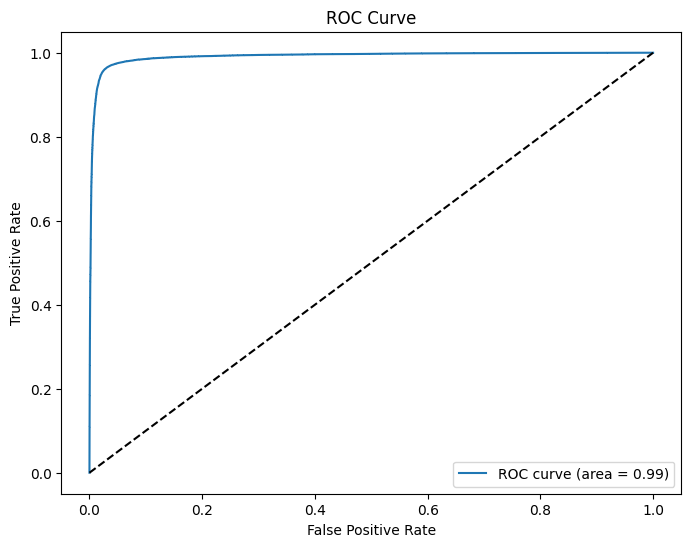

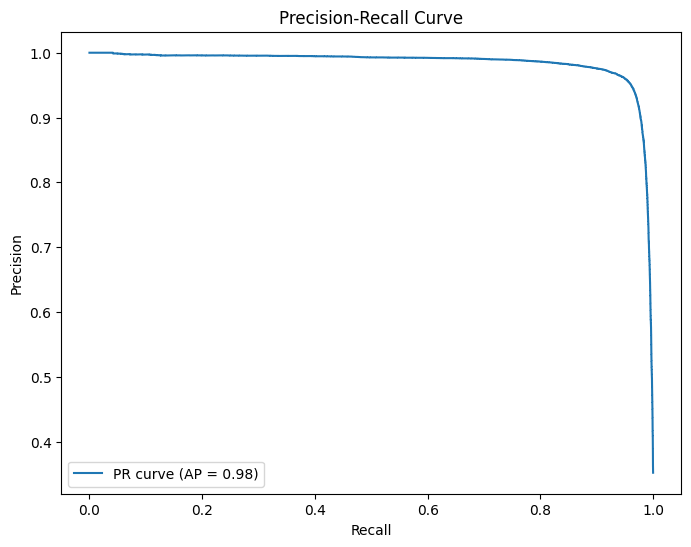

In [22]:
Predict_module = PredictDataModule(
    csv_file="/home/jupyter/Data/meta_npy.csv",  #--meta_file
    allowed_set=["test"],  #训练还是测试
    allowed_data_source='all',
    # ['itw', 'gen', 'LJSpeech', 'vox', 'diffusion-based'] 去掉diffusion-based train的话应该就能得到不太好的eer泛化
    batch_size=128,  #训练batch_size
    num_workers_csv=96,  #多线程读取csv的
    num_workers_dataset=0
)

Predict_module.setup()
predict_loader = Predict_module.get_loader()
evaluator = ModelEvaluation(trainer.model, device, predict_loader, weight_path="conformerv411.pt", threshold=0.9)
evaluator.load_model()
evaluator.predict()
evaluator.evaluate()

In [26]:
Predict_module = PredictDataModule(
    csv_file="/home/jupyter/Data/meta_npy.csv",  #--meta_file
    allowed_set=["test"],  #训练还是测试
    allowed_data_source=["diffusion-based", 'gen'],
    # ['itw', 'gen', 'LJSpeech', 'vox', 'diffusion-based'] 去掉diffusion-based train的话应该就能得到不太好的eer泛化
    batch_size=128,  #训练batch_size
    num_workers_csv=96,  #多线程读取csv的
    num_workers_dataset=0
)

Predict_module.setup()
predict_loader = Predict_module.get_loader()
evaluator = ModelEvaluation(trainer.model, device, predict_loader, weight_path="conformerv411.pt", threshold=0.9)
evaluator.load_model()
evaluator.predict()
evaluator.evaluate()

Loading audio info from CSV:   0%|          | 0/65500 [00:00<?, ?it/s]

Model loaded from conformerv411.pt


Predicting:   0%|          | 0/512 [00:00<?, ?it/s]

Prediction completed.
Evaluation Metrics:
Accuracy: 0.9999
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
AUC Score: NaN
Average Precision: NaN
EER: NaN
Confusion Matrix:
[[65494     6]
 [    0     0]]


In [24]:
Predict_module = PredictDataModule(
    csv_file="/home/jupyter/Data/meta_npy.csv",  #--meta_file
    allowed_set=["test"],  #训练还是测试
    allowed_data_source=["vox"],
    # ['itw', 'gen', 'LJSpeech', 'vox', 'diffusion-based'] 去掉diffusion-based train的话应该就能得到不太好的eer泛化
    batch_size=128,  #训练batch_size
    num_workers_csv=96,  #多线程读取csv的
    num_workers_dataset=0
)

Predict_module.setup()
predict_loader = Predict_module.get_loader()
evaluator = ModelEvaluation(trainer.model, device, predict_loader, weight_path="conformerv411.pt", threshold=0.9)
evaluator.load_model()
evaluator.predict()
evaluator.evaluate()

Loading audio info from CSV:   0%|          | 0/30315 [00:00<?, ?it/s]

Model loaded from conformerv411.pt


Predicting:   0%|          | 0/237 [00:00<?, ?it/s]

Prediction completed.
Evaluation Metrics:
Accuracy: 0.9420
Precision: 1.0000
Recall: 0.9420
F1 Score: 0.9701
AUC Score: NaN
Average Precision: NaN
EER: NaN
Confusion Matrix:
[[    0     0]
 [ 1758 28557]]


Loading audio info from CSV:   0%|          | 0/15774 [00:00<?, ?it/s]

Model loaded from conformerv411.pt


Predicting:   0%|          | 0/124 [00:00<?, ?it/s]

Prediction completed.
Evaluation Metrics:
Accuracy: 0.8059
Precision: 0.7869
Recall: 0.9031
F1 Score: 0.8410
AUC Score: 0.8787241337762256
Average Precision: 0.8859573223219442
EER: 0.19694521956234395
Confusion Matrix:
[[4616 2193]
 [ 869 8096]]


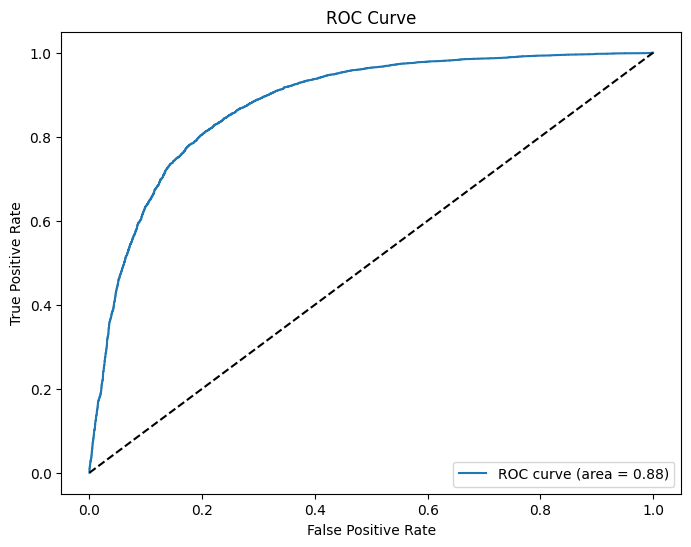

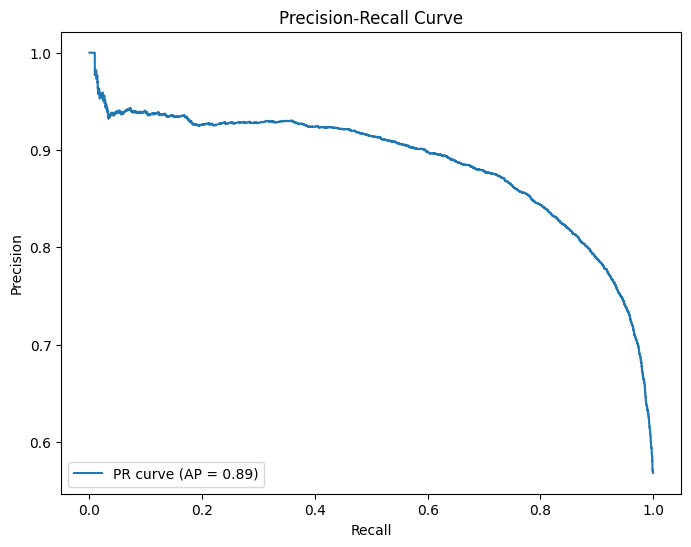

In [28]:
Predict_module = PredictDataModule(
    csv_file="/home/jupyter/Data/meta_npy.csv",  #--meta_file
    allowed_set=["test"],  #训练还是测试
    allowed_data_source=["itw"],
    # ['itw', 'gen', 'LJSpeech', 'vox', 'diffusion-based'] 去掉diffusion-based train的话应该就能得到不太好的eer泛化
    batch_size=128,  #训练batch_size
    num_workers_csv=96,  #多线程读取csv的
    num_workers_dataset=0
)

Predict_module.setup()
predict_loader = Predict_module.get_loader()
evaluator = ModelEvaluation(trainer.model, device, predict_loader, weight_path="conformerv411.pt", threshold=0.5)
evaluator.load_model()
evaluator.predict()
evaluator.evaluate()

In [40]:
Predict_module = PredictDataModule(
    csv_file="/home/jupyter/Data/meta_npy.csv",  #--meta_file
    allowed_set=["test"],  #训练还是测试
    allowed_data_source=["gen"],
    # ['itw', 'gen', 'LJSpeech', 'vox', 'diffusion-based'] 去掉diffusion-based train的话应该就能得到不太好的eer泛化
    batch_size=128,  #训练batch_size
    num_workers_csv=96,  #多线程读取csv的
    num_workers_dataset=0
)

Predict_module.setup()
predict_loader = Predict_module.get_loader()
evaluator = ModelEvaluation(trainer.model, device, predict_loader, weight_path="conformerv411.pt", threshold=0.9)
evaluator.load_model()
evaluator.predict()
evaluator.evaluate()

Loading audio info from CSV:   0%|          | 0/26200 [00:00<?, ?it/s]

Model loaded from conformerv411.pt


Predicting:   0%|          | 0/205 [00:00<?, ?it/s]

Prediction completed.
Evaluation Metrics:
Accuracy: 0.9958
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
AUC Score: NaN
Average Precision: NaN
EER: NaN
Confusion Matrix:
[[26091   109]
 [    0     0]]


Loading audio info from CSV:   0%|          | 0/19409 [00:00<?, ?it/s]

Model loaded from conformerv411.pt


Predicting:   0%|          | 0/152 [00:00<?, ?it/s]

Prediction completed.
Evaluation Metrics:
Accuracy: 0.9423
Precision: 0.9981
Recall: 0.8492
F1 Score: 0.9176
AUC Score: 0.9937787855618345
Average Precision: 0.9911564895207587
EER: 0.03821920079588791
Confusion Matrix:
[[12050    12]
 [ 1108  6239]]


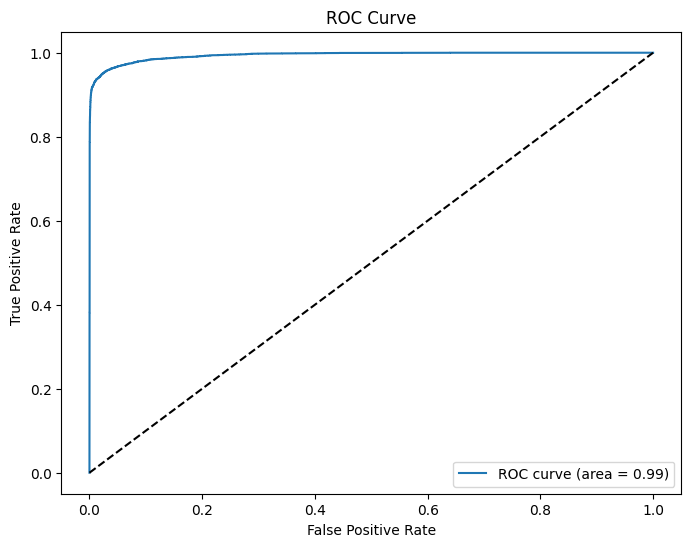

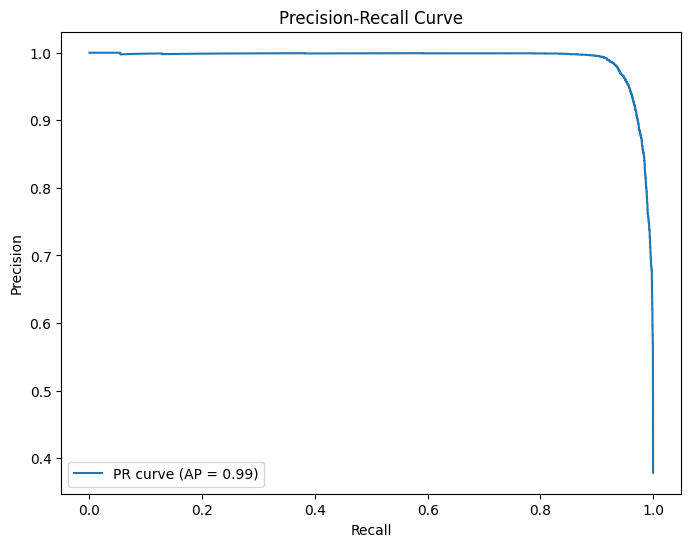

In [30]:
Predict_module = PredictDataModule(
    csv_file="/home/jupyter/Data/meta_npy.csv",  #--meta_file
    allowed_set=["in-test"],  #训练还是测试
    allowed_data_source='all',
    # ['itw', 'gen', 'LJSpeech', 'vox', 'diffusion-based'] 去掉diffusion-based train的话应该就能得到不太好的eer泛化
    batch_size=128,  #训练batch_size
    num_workers_csv=96,  #多线程读取csv的
    num_workers_dataset=0
)

Predict_module.setup()
predict_loader = Predict_module.get_loader()
evaluator = ModelEvaluation(trainer.model, device, predict_loader, weight_path="conformerv411.pt", threshold=0.9)
evaluator.load_model()
evaluator.predict()
evaluator.evaluate()

Loading audio info from CSV:   0%|          | 0/800 [00:00<?, ?it/s]

Model loaded from conformerv411.pt


Predicting:   0%|          | 0/7 [00:00<?, ?it/s]

Prediction completed.
Evaluation Metrics:
Accuracy: 0.8425
Precision: 0.9721
Recall: 0.7857
F1 Score: 0.8690
AUC Score: 0.9640542587812815
Average Precision: 0.9680796674318677
EER: 0.1044776119402985
Confusion Matrix:
[[256  12]
 [114 418]]


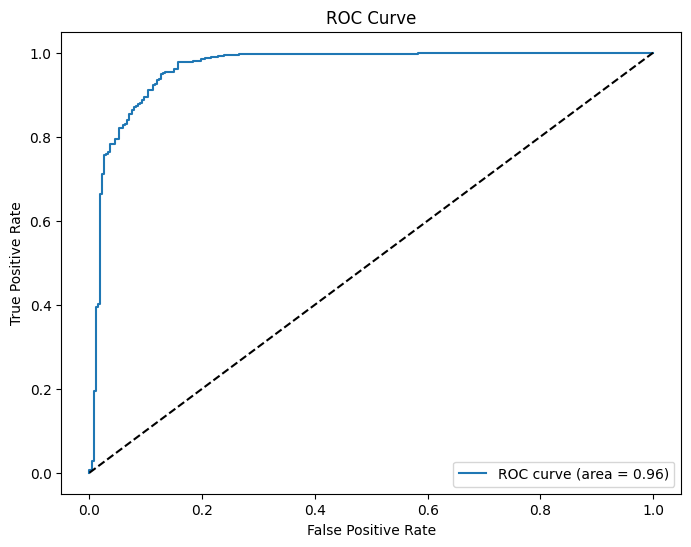

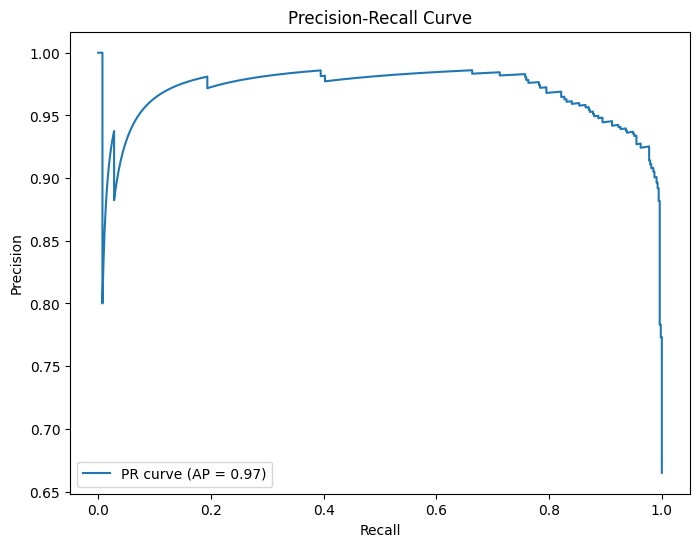

In [31]:
Predict_module = PredictDataModule(
    csv_file="/home/jupyter/Data/meta_npy.csv",  #--meta_file
    allowed_set=["in-test"],  #训练还是测试
    allowed_data_source=['itw'],
    # ['itw', 'gen', 'LJSpeech', 'vox', 'diffusion-based'] 去掉diffusion-based train的话应该就能得到不太好的eer泛化
    batch_size=128,  #训练batch_size
    num_workers_csv=96,  #多线程读取csv的
    num_workers_dataset=0
)

Predict_module.setup()
predict_loader = Predict_module.get_loader()
evaluator = ModelEvaluation(trainer.model, device, predict_loader, weight_path="conformerv411.pt", threshold=0.9)
evaluator.load_model()
evaluator.predict()
evaluator.evaluate()

In [33]:
Predict_module = PredictDataModule(
    csv_file="/home/jupyter/Data/meta_npy.csv",  #--meta_file
    allowed_set=["in-test"],  #训练还是测试
    allowed_data_source=['gen', 'diffusion-based'],
    # ['itw', 'gen', 'LJSpeech', 'vox', 'diffusion-based'] 去掉diffusion-based train的话应该就能得到不太好的eer泛化
    batch_size=128,  #训练batch_size
    num_workers_csv=96,  #多线程读取csv的
    num_workers_dataset=0
)

Predict_module.setup()
predict_loader = Predict_module.get_loader()
evaluator = ModelEvaluation(trainer.model, device, predict_loader, weight_path="conformerv411.pt", threshold=0.9)
evaluator.load_model()
evaluator.predict()
evaluator.evaluate()

Loading audio info from CSV:   0%|          | 0/11794 [00:00<?, ?it/s]

Model loaded from conformerv411.pt


Predicting:   0%|          | 0/93 [00:00<?, ?it/s]

Prediction completed.
Evaluation Metrics:
Accuracy: 1.0000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
AUC Score: NaN
Average Precision: NaN
EER: NaN
Confusion Matrix:
[[11794]]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


In [34]:
Predict_module = PredictDataModule(
    csv_file="/home/jupyter/Data/meta_npy.csv",  #--meta_file
    allowed_set=["in-test"],  #训练还是测试
    allowed_data_source=['vox'],
    # ['itw', 'gen', 'LJSpeech', 'vox', 'diffusion-based'] 去掉diffusion-based train的话应该就能得到不太好的eer泛化
    batch_size=128,  #训练batch_size
    num_workers_csv=96,  #多线程读取csv的
    num_workers_dataset=0
)

Predict_module.setup()
predict_loader = Predict_module.get_loader()
evaluator = ModelEvaluation(trainer.model, device, predict_loader, weight_path="conformerv411.pt", threshold=0.9)
evaluator.load_model()
evaluator.predict()
evaluator.evaluate()

Loading audio info from CSV:   0%|          | 0/6160 [00:00<?, ?it/s]

Model loaded from conformerv411.pt


Predicting:   0%|          | 0/49 [00:00<?, ?it/s]

Prediction completed.
Evaluation Metrics:
Accuracy: 0.9450
Precision: 1.0000
Recall: 0.9450
F1 Score: 0.9717
AUC Score: NaN
Average Precision: NaN
EER: NaN
Confusion Matrix:
[[   0    0]
 [ 339 5821]]


In [29]:
Predict_module = PredictDataModule(
    csv_file="/home/jupyter/Data/11lab_npy.csv",  #--meta_file
    allowed_set=["test"],  #训练还是测试
    allowed_data_source='all',
    # ['itw', 'gen', 'LJSpeech', 'vox', 'diffusion-based'] 去掉diffusion-based train的话应该就能得到不太好的eer泛化
    batch_size=128,  #训练batch_size
    num_workers_csv=96,  #多线程读取csv的
    num_workers_dataset=0
)

Predict_module.setup()
predict_loader = Predict_module.get_loader()
evaluator = ModelEvaluation(trainer.model, device, predict_loader, weight_path="conformerv411.pt", threshold=0.9)
evaluator.load_model()
evaluator.predict()
evaluator.evaluate()

Loading audio info from CSV:   0%|          | 0/631 [00:00<?, ?it/s]

Model loaded from conformerv411.pt


Predicting:   0%|          | 0/5 [00:00<?, ?it/s]

Prediction completed.
Evaluation Metrics:
Accuracy: 0.7290
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
AUC Score: NaN
Average Precision: NaN
EER: NaN
Confusion Matrix:
[[460 171]
 [  0   0]]


In [33]:
import progressbar


class NPYPredictDataset(Dataset):
    def __init__(self, csv_file):
        self.df = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # 构造 npy 文件的完整路径：以 absolute_path 为根目录，加上 relative_path（即文件名）
        absolute_path = row["npy_path"]
        wav_name = row["relative_path"]
        # full_path = os.path.join(absolute_path, relative_path)

        try:
            data = np.load(absolute_path)
        except Exception as e:
            print(f"Error loading {absolute_path}: {e}")
            # # 默认返回一个全 0 的数组，形状可根据实际情况调整
            # data = np.zeros((1, 40, 400), dtype=np.float32)

        # 如果数据仅为二维形状 (n_mfcc, frames)，扩展 channel 维度
        if data.ndim == 2:
            data = np.expand_dims(data, axis=0)

        tensor_data = torch.tensor(data, dtype=torch.float32)
        return tensor_data, wav_name


# -------------------------------------------
# 批量预测函数
# -------------------------------------------
def predict_npy_files(model, device, csv_file, batch_size=16, threshold=0.9):
    dataset = NPYPredictDataset(csv_file)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    model.eval()
    results = []
    with torch.no_grad():
        for i, batch in tqdm(enumerate(loader)):
            inputs, wavs = batch  # wavs 为 CSV 中的 relative_path（文件名）
            inputs = inputs.to(device)
            outputs = model(inputs).squeeze(1)
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs >= threshold).astype(int)

            for wav, prob, pred in zip(wavs, probs, preds):
                results.append((wav, prob, int(pred)))
    return results


# -------------------------------------------
# 示例：加载模型，预测并输出结果
# -------------------------------------------
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Conformer(input_dim=40, d_model=32, d_ff=64, num_heads=4, num_layers=6, dropout=0.1, kernel_size=7,
                      num_classes=1).to(device)
    model.load_state_dict(torch.load("conformerv411.pt", map_location=device))
    model.eval()

    csv_file = "../Data/11lab_npy.csv"

    results = predict_npy_files(model, device, csv_file, batch_size=1, threshold=0.9)
    pd.DataFrame(results, columns=['wav', 'prob', 'pred']).to_csv('11lab_res.csv', index=False)

0it [00:00, ?it/s]

In [34]:
res = pd.read_csv('11lab_res.csv')

In [35]:
res.pred.value_counts()

pred
0    460
1    171
Name: count, dtype: int64